In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime as dt
import pprint

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# reflect the tables
Base=automap_base()
Base.prepare(engine, reflect=True)



In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement= Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
def calc_temps(start_date, end_date): 
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
Yr_2015=calc_temps('2015-12-15', '2015-12-31')
YR_df=pd.DataFrame(Yr_2015, columns=["t_min", "t_avg", "t_max"])
YR_df

,t_min,t_avg,t_max
0,67.0,73.676768,82.0


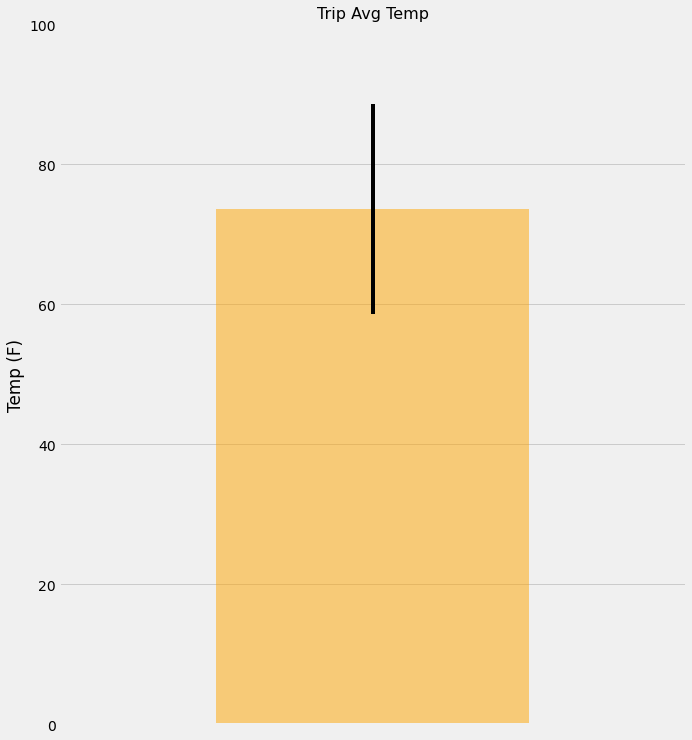

In [12]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
YR_df=pd.DataFrame(Yr_2015, columns=["t_min", "t_avg", "t_max"])
error=YR_df['t_max']-YR_df['t_min']

plt.figure(figsize=(10, 12))
ax=YR_df["t_avg"].plot.bar( yerr=error, alpha=0.50, color='orange')
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp",fontsize=16)
plt.ylim(0, 100)
ax.axes.get_xaxis().set_visible(False)

plt.savefig("Images/Trip_Avg_Temp.png")


### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
start_date = '2014-12-15'
end_date = '2014-12-31'
Rain_data = (session.query(Measurement.date,Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.avg(Measurement.prcp))
.filter(Measurement.date.between(start_date, end_date))
.filter(Measurement.station == Station.station)
.group_by(Station.station)        
.order_by(func.avg(Measurement.prcp).desc())
.all())
             
rain_df=pd.DataFrame(Rain_data, columns=['date','station','name','latitude','longitude','elevation','prcp'])
rain_df[['station','name','latitude','longitude','elevation','prcp']]
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


,station,name,latitude,longitude,elevation,prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.592308
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.258667
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.207647
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.201176
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.105000
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.063529
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.049412
7,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.043333


In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
start_date = '2015-12-15'
end_date = '2015-12-31'

start_date = dt.datetime(2015 ,12, 15)
end_date = dt.datetime(2015 ,12, 31)
new_date=pd.date_range(start_date, end_date)

# Strip off the year and save a list of strings in the format %m-%d
dates = [date.strftime("%m-%d") for date in new_date]

# Use the `daily_normals` function to calculate the normals for each date string 
   

normals = [daily_normals(date)[0] for date in dates]
normals
# and append the results to a list called `normals`.

[(62.0, 71.34, 79.0),
 (60.0, 69.62264150943396, 82.0),
 (63.0, 70.64, 77.0),
 (63.0, 71.28, 77.0),
 (67.0, 72.0, 78.0),
 (65.0, 72.91304347826087, 81.0),
 (67.0, 72.13953488372093, 78.0),
 (67.0, 71.1304347826087, 77.0),
 (61.0, 70.34693877551021, 78.0),
 (62.0, 70.0625, 78.0),
 (60.0, 71.75, 79.0),
 (63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0),
 (62.0, 70.52083333333333, 77.0),
 (57.0, 70.29166666666667, 78.0),
 (63.0, 69.86363636363636, 76.0),
 (56.0, 68.27906976744185, 77.0)]

In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df=pd.DataFrame(normals, columns=["min", "avg", "max"], index=new_date)
normals_df.index.name='Date'
normals_df

,min,avg,max
Date,,,
2015-12-15,62.0,71.340000,79.0
2015-12-16,60.0,69.622642,82.0
2015-12-17,63.0,70.640000,77.0
2015-12-18,63.0,71.280000,77.0
2015-12-19,67.0,72.000000,78.0
2015-12-20,65.0,72.913043,81.0
2015-12-21,67.0,72.139535,78.0
2015-12-22,67.0,71.130435,77.0
2015-12-23,61.0,70.346939,78.0


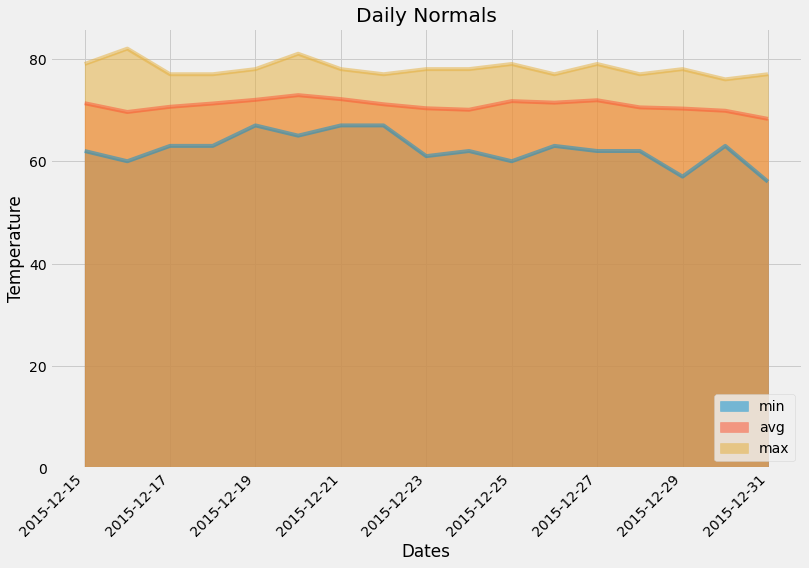

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.reset_index()
normals_df.plot(kind="area", stacked=False,figsize=(12,9),x_compat=True)
plt.title("Daily Normals")
plt.xticks(rotation=45)
plt.yticks(np.arange(0,100, step=20))
plt.legend(loc='lower right')
plt.xlabel('Dates')
plt.ylabel('Temperature')
plt.savefig("Images/Daily Normals.png")

## Close Session

In [18]:
session.close()